In [1]:
import os
import torch
import librosa
import torchaudio
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchaudio.transforms as T
from sklearn.utils import shuffle
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split

In [2]:
torch.manual_seed(42)
Dataset_x=torch.tensor([])
Dataset_y=torch.tensor([])

mel_spec_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=44100,
    n_mels=80,
    n_fft=1024,
    hop_length=256
)
spec_transform = torchaudio.transforms.Spectrogram(
    n_fft=159,
    hop_length=256
)

major_path="./Audio_Files/Major/"
for filename in os.listdir(major_path):
    f = os.path.join(major_path, filename)
    waveform,sr=torchaudio.load(f)
    #waveform = torchaudio.functional.lowpass_biquad(waveform,sr,5000)
    waveform1=mel_spec_transform(waveform)
    waveform2=spec_transform(waveform)
    waveform3=torch.abs(torch.stft(waveform,n_fft=159,return_complex=True,hop_length=256))
    waveform1=torch.nn.functional.pad(waveform1, (0, 400-waveform1.shape[2]), mode='constant', value=0)
    waveform2=torch.nn.functional.pad(waveform2, (0, 400-waveform2.shape[2]), mode='constant', value=0)
    waveform3=torch.nn.functional.pad(waveform3, (0, 400-waveform3.shape[2]), mode='constant', value=0)
    waveform=torch.cat((waveform1,waveform2,waveform3))
    waveform=waveform.unsqueeze(0)
    Dataset_x=torch.cat((Dataset_x,waveform))
    Dataset_y=torch.cat((Dataset_y,torch.tensor([[1]])))

minor_path="./Audio_Files/Minor/"
for filename in os.listdir(minor_path):
    f = os.path.join(minor_path, filename)
    waveform,sr=torchaudio.load(f)
    #waveform = torchaudio.functional.lowpass_biquad(waveform,sr,5000)
    waveform1=mel_spec_transform(waveform)
    waveform2=spec_transform(waveform)
    waveform3=torch.abs(torch.stft(waveform,n_fft=159,return_complex=True,hop_length=256))
    waveform1=torch.nn.functional.pad(waveform1, (0, 400-waveform1.shape[2]), mode='constant', value=0)
    waveform2=torch.nn.functional.pad(waveform2, (0, 400-waveform2.shape[2]), mode='constant', value=0)
    waveform3=torch.nn.functional.pad(waveform3, (0, 400-waveform3.shape[2]), mode='constant', value=0)
    waveform=torch.cat((waveform1,waveform2,waveform3))
    waveform=waveform.unsqueeze(0)
    Dataset_x=torch.cat((Dataset_x,waveform))
    Dataset_y=torch.cat((Dataset_y,torch.tensor([[0]])))
Dataset_x,Dataset_y=shuffle(Dataset_x,Dataset_y)
Dataset_x.shape

torch.Size([859, 3, 80, 400])

In [3]:
train_x, rem_x, train_y,rem_y = train_test_split(Dataset_x,Dataset_y, train_size=0.7,shuffle=True)
val_x,test_x,val_y,test_y=train_test_split(rem_x,rem_y, train_size=0.5,shuffle=True)


Time_transform=torchaudio.transforms.TimeMasking(time_mask_param=20,p=0.7)
Freq_transform=torchaudio.transforms.FrequencyMasking(freq_mask_param=20)
Volume_transform=torchaudio.transforms.Vol(gain=0.5)

indx=0
a=Time_transform(train_x)
b=Freq_transform(train_x)
c=Volume_transform(train_x)
train_x=torch.cat((train_x,a,b,c))
train_y=torch.cat((train_y,train_y,train_y,train_y))

train_x,train_y=shuffle(train_x,train_y)
mean = train_x.mean()
std = train_x.std()
train_x = (train_x - mean) / std
val_x = (val_x - mean) / std
test_x = (test_x - mean) / std

In [4]:
def weight_init(m):
    if isinstance(m,nn.Conv2d):
        torch.nn.init.kaiming_uniform_(m.weight)
        m.bias.data.fill_(0)
    if isinstance(m,nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

class CNN(nn.Module):
    def __init__(self,shape):
        super(CNN,self).__init__()
        self.conv1=nn.Sequential(
            nn.Conv2d(
            in_channels=3,
            out_channels=32,
            kernel_size=4,
            padding=3,
            stride=2
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.15)
        )
        self.conv1.apply(weight_init)
        self.conv2=nn.Sequential(
            nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=4,
            padding=3,
            stride=2
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.15)
        )
        self.conv2.apply(weight_init)
        self.conv3=nn.Sequential(
            nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=4,
            padding=3,
            stride=2
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.15)
        )
        self.conv4=nn.Sequential(
            nn.Conv2d(
            in_channels=128,
            out_channels=128,
            kernel_size=4,
            padding=3,
            stride=2
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.15)
        )
        self.conv4.apply(weight_init)
        conv_size=self._get_conv_out(shape)
        self.linear1=nn.Linear(conv_size,128)
        self.linear1.apply(weight_init)
        self.linear2=nn.Linear(128,1)
        self.linear2.apply(weight_init)

    def _get_conv_out(self,shape):
        out = self.conv1(torch.zeros(1,*shape))
        out=self.conv2(out)
        out=self.conv3(out)
        out=self.conv4(out)
        result = int(np.prod(out.size()))
        return result
    
    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=x.view(x.size(0),-1)
        x=self.linear1(x)
        x=self.linear2(x)
        x=torch.sigmoid(x)
        return x

Epoch: 0, Train Loss: 0.0137981, Train Accu: 0.545, Validation Loss: 0.0052861, Validation Accu: 0.589
Epoch: 1, Train Loss: 0.0074764, Train Accu: 0.564, Validation Loss: 0.0058592, Validation Accu: 0.589
Epoch: 2, Train Loss: 0.0073943, Train Accu: 0.576, Validation Loss: 0.0052806, Validation Accu: 0.558
Epoch: 3, Train Loss: 0.0067158, Train Accu: 0.615, Validation Loss: 0.0053025, Validation Accu: 0.566
Epoch: 4, Train Loss: 0.0064593, Train Accu: 0.642, Validation Loss: 0.0057455, Validation Accu: 0.605
Epoch: 5, Train Loss: 0.0060948, Train Accu: 0.678, Validation Loss: 0.0056591, Validation Accu: 0.597
Epoch: 6, Train Loss: 0.0057619, Train Accu: 0.700, Validation Loss: 0.0054434, Validation Accu: 0.612
Epoch: 7, Train Loss: 0.0053148, Train Accu: 0.724, Validation Loss: 0.0058531, Validation Accu: 0.620
Epoch: 8, Train Loss: 0.0049135, Train Accu: 0.752, Validation Loss: 0.0059561, Validation Accu: 0.651
Epoch: 9, Train Loss: 0.0045926, Train Accu: 0.770, Validation Loss: 0.00

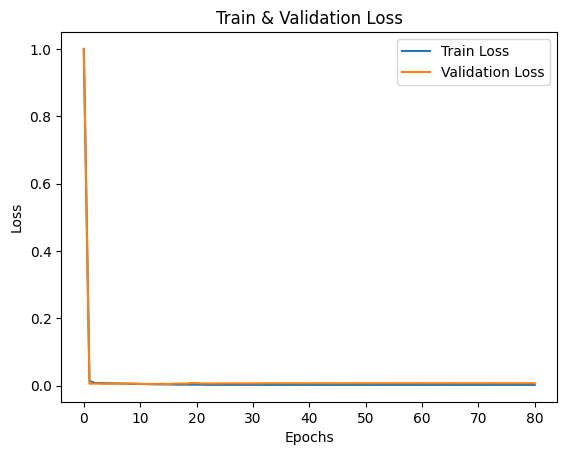

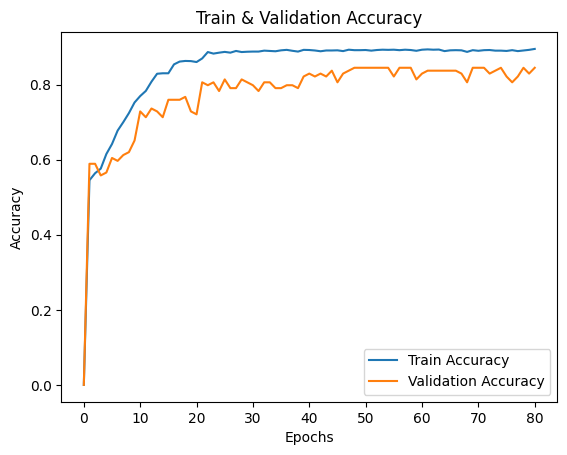

In [5]:
epochs=80
batch=100
device=torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
model=CNN(train_x[0].shape)
model=model.to(device)
criterion=nn.BCELoss()
optimizer=optim.Adam(model.parameters(),lr=0.001,weight_decay=10e-4)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

train_loss=[1]
train_accu=[0]
val_loss=[1]
val_accu=[0]

for epoch in range(epochs):
    l=0
    a=0
    batch_num=0
    for i in range(0,len(train_x),batch): 
        model.train()
        batch_num+=1
        x_batch = train_x[i:i+batch] 
        y_batch = train_y[i:i+batch]
        out=model(x_batch)
        loss=criterion(out,y_batch)
        l+=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        a+=(torch.round(out)==y_batch).sum().float()
    scheduler.step()
    train_loss.append(l/len(train_x))
    train_accu.append(a/len(train_x))
    
    model.eval()
    with torch.no_grad():
        out=model(val_x)
        loss=criterion(out,val_y)
        val_accu.append((torch.round(out)==val_y).sum().float()/len(val_x))
        val_loss.append(loss.item()/len(val_x))
    print("Epoch: {}, Train Loss: {:0.7f}, Train Accu: {:0.3f}, Validation Loss: {:0.7f}, Validation Accu: {:0.3f}"
          .format(epoch,train_loss[-1],train_accu[-1].numpy(),val_loss[-1],val_accu[-1].numpy()))

plt.plot(range(epochs+1),train_loss)
plt.plot(range(epochs+1),val_loss)
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train & Validation Loss')
plt.show()

plt.plot(range(epochs+1),train_accu)
plt.plot(range(epochs+1),val_accu)
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train & Validation Accuracy')
plt.show()

In [6]:
model.eval()
with torch.no_grad():
    out=model(test_x)
    print("Test Accuracy: ",((torch.round(out)==test_y).sum().float()/len(test_x)).numpy())

Test Accuracy:  0.7596899
